In [28]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from scipy.sparse import save_npz, load_npz
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

### Load and prepare data

In [2]:
DATA_DIR = os.path.join('..', 'data', 'processed', 'sparse')

In [3]:
train_ratings = load_npz(os.path.join(DATA_DIR, 'train_ratings.npz'))
test_ratings = load_npz(os.path.join(DATA_DIR, 'test_ratings.npz'))

In [4]:
M, N = train_ratings.shape
M, N

(9166, 1998)

In [5]:
# create mask of locations where sparse matrices have nonzero values
train_mask = (train_ratings > 0).astype(np.uint8)
test_mask = (test_ratings > 0).astype(np.uint8)

In [6]:
# compute global mean
mean = train_ratings.sum() / train_mask.sum()
mean

4.2368585786572535

### Build the model

In [7]:
def build_model(M, N, K, lmbda=0.):
    """
    Build a model for matrix factorization
    Args:
        M (int): number of users
        N (int): number of items
        K (int): size of hidden layer
        lmbda (float): L2-regularization parameter
    Returns:
        keras.models.Model: model for MF
    """
    user_vector = Input((N, )) 
    
    noisy_user_vector = Dropout(rate=0.8)(user_vector)
    hidden = Dense(K, activation='relu', kernel_regularizer=l2(lmbda))(noisy_user_vector)
    output = Dense(N, kernel_regularizer=l2(lmbda))(hidden)
    
    model = Model(user_vector, output)
    
    return model

### Example of keras-model architecture

In [8]:
model = build_model(M, N, K=900, lmbda=0.001)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1998)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1998)              0         
_________________________________________________________________
dense (Dense)                (None, 900)               1799100   
_________________________________________________________________
dense_1 (Dense)              (None, 1998)              1800198   
Total params: 3,599,298
Trainable params: 3,599,298
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [10]:
def sparse_mse(y_true, y_pred):
    true_mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    sq_residuals = ((y_pred - y_true) ** 2) * true_mask # include only residual from non zero inputs
    return tf.reduce_sum(sq_residuals) / tf.reduce_sum(true_mask)

def sparse_rmse(y_true, y_pred):
    return tf.sqrt(sparse_mse(y_true, y_pred))

#### Define data generators

In [11]:
def train_datagen(train_ratings, train_mask, batch_size=128):
    while True:
        train_ratings, train_mask = shuffle(train_ratings, train_mask)
        steps = train_ratings.shape[0] // batch_size
        for step in range(steps):
            train_batch = train_ratings[step * batch_size:(step + 1) * batch_size].toarray()
            mask_batch = train_mask[step * batch_size:(step + 1) * batch_size].toarray()  
            # normilize nonzero values
            train_batch = train_batch - mean * mask_batch
            yield train_batch, train_batch

def test_datagen(train_ratings, train_mask, test_ratings, test_mask, batch_size=128):
    while True:
        steps = train_ratings.shape[0] // batch_size
        for step in range(steps):
            train_batch = train_ratings[step * batch_size:(step + 1) * batch_size].toarray()
            mask_batch = train_mask[step * batch_size:(step + 1) * batch_size].toarray() 
            test_batch = test_ratings[step * batch_size:(step + 1) * batch_size].toarray()
            test_mask_batch = test_mask[step * batch_size:(step + 1) * batch_size].toarray() 
            # normilize nonzero values
            train_batch = train_batch - mean * mask_batch
            test_batch = test_batch - mean * test_mask_batch
            
            yield train_batch, test_batch

In [12]:
LOSS = sparse_mse
LR = 0.1
RATE_DECAY = 0
EPOCHS = 100
BATCH_SIZE = 256

In [13]:
model.compile(
    loss=LOSS,
    optimizer=SGD(lr=LR, decay=RATE_DECAY, momentum=0.9),
    metrics=[sparse_rmse]
)

In [14]:
history = model.fit_generator(
    train_datagen(train_ratings, train_mask, batch_size=BATCH_SIZE),
    validation_data=test_datagen(train_ratings, train_mask, test_ratings, test_mask, batch_size=BATCH_SIZE),
    steps_per_epoch=train_ratings.shape[0] // BATCH_SIZE,
    validation_steps=test_ratings.shape[0] // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
35/35 [==============================] - 4s 114ms/step - loss: 3.3564 - sparse_rmse: 0.9872 - val_loss: 3.1887 - val_sparse_rmse: 0.9734
Epoch 2/100
35/35 [==============================] - 4s 107ms/step - loss: 2.9724 - sparse_rmse: 0.9373 - val_loss: 2.8820 - val_sparse_rmse: 0.9628
Epoch 3/100
35/35 [==============================] - 4s 108ms/step - loss: 2.6643 - sparse_rmse: 0.9159 - val_loss: 2.6196 - val_sparse_rmse: 0.9551
Epoch 4/100
35/35 [==============================] - 4s 112ms/step - loss: 2.4043 - sparse_rmse: 0.8998 - val_loss: 2.3921 - val_sparse_rmse: 0.9479
Epoch 5/100
35/35 [==============================] - 4s 115ms/step - loss: 2.1779 - sparse_rmse: 0.8845 - val_loss: 2.1956 - val_sparse_rmse: 0.9415
Epoch 6/100
35/35 [==============================] - 4s 124ms/step - loss: 1.9893 - sparse_rmse: 0.8752 - val_loss: 2.0256 - val_sparse_rmse: 0.9358
Epoch 7/100
35/35 [==============================] - 5s 132ms/step - loss: 1.8259 - sparse_rmse: 0.8668 - 

In [19]:
loss, rmse =model.evaluate_generator(test_datagen(train_ratings, train_mask, test_ratings, test_mask, batch_size=BATCH_SIZE),
                        steps =test_ratings.shape[0] // BATCH_SIZE)
rmse

0.8992441

In [20]:
history.history

{'loss': [3.3563952990940638,
  2.9723929882049562,
  2.664303963524955,
  2.4042547362191335,
  2.1779433795384,
  1.9892740658351353,
  1.825876750264849,
  1.6873379502977643,
  1.5621321303503855,
  1.4642350843974523,
  1.3729245492390223,
  1.2951657363346645,
  1.2276193107877458,
  1.174105954170227,
  1.1213595799037388,
  1.0807809693472725,
  1.045654276439122,
  1.0126252395766122,
  0.9900012271744865,
  0.9625044294766018,
  0.94877439056124,
  0.9236426608903068,
  0.916855183669499,
  0.8942281637872969,
  0.8847931146621704,
  0.8777058362960816,
  0.8684929473059518,
  0.8598223890577044,
  0.8576290999140058,
  0.846954255444663,
  0.8421123930386134,
  0.8377841847283499,
  0.8340736218861171,
  0.8308380825178964,
  0.8289679884910583,
  0.8228711349623544,
  0.8247798340661185,
  0.8253710474286761,
  0.8208719849586487,
  0.8150906239237105,
  0.8152913842882429,
  0.8141214506966727,
  0.8181859833853585,
  0.8134121247700282,
  0.8150405713490078,
  0.809271405

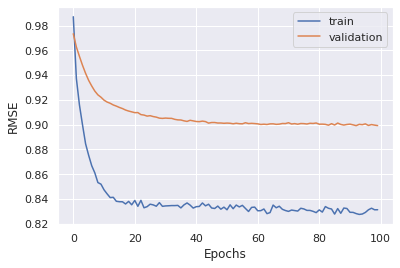

In [30]:
sns.lineplot(np.arange(len(history.history['sparse_rmse'])), history.history['sparse_rmse'])
sns.lineplot(np.arange(len(history.history['sparse_rmse'])), history.history['val_sparse_rmse'])
plt.legend(['train', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('RMSE');
plt.savefig("autorec.png")